# Combine Twitter Posts

## Step 1 - Format the Play by Play Tweet Data

In [365]:
import pandas as pd
from datetime import timedelta

df = pd.read_csv('../../data/all_pbp_tweets.tar.gz')

# Drop the rows that are just repeats of the header
df = df.drop(df.loc[df['created_at'] == 'created_at'].index)

# Drop columns that don't contain meaninful data
df = df.drop(['location','time_zone'], axis=1)

# Convert created_at to datetime
df['UTC_Datetime'] = pd.to_datetime(df['created_at'])

# Rename column to tweet id and make it the index
df = df.rename(columns={'cardinals_pbp_tweets.csv':'tweet_id'}).set_index('tweet_id')

# make the tweet_id numeric
df.index = pd.to_numeric(df.index)

# Drop a single annoying NA row
df = df.loc[df.index.dropna()] # Drop this annoying

# Make year and time columns
df['time'] = df['UTC_Datetime'].apply(lambda x: x.time())
df['date'] = df['UTC_Datetime'].apply(lambda x: x.date())

# Sort by the timestamp
df = df.sort_values('UTC_Datetime')

# Reorder the columns in the dataframe
df = df[['UTC_Datetime','date','time','screen_name','source','text']]

# Only Games from 2017 Season and name pbptweets
df = df.loc[df['UTC_Datetime'] > '04-Sep-2017']

pbptweets = df.copy()

print("PBP Tweets length:", len(pbptweets))

pbptweets['gamedate'] = pbptweets['UTC_Datetime'].apply(lambda x: (x - timedelta(hours=12)).date())

# Create Team Name Columns
pbptweets['Team1'] = pbptweets['source'].apply(lambda x: x.split(' ')[0])
pbptweets['Team2'] = pbptweets['source'].apply(lambda x: x.split(' ')[0])
pbptweets = pbptweets.replace(to_replace='Buccaneer', value='Buccaneers')


pbptweets = pbptweets.reset_index()

winpct = pd.read_csv('../../data/All_Games_Win_Pct.csv')

# Call the play text the same thing as the other dataframe
winpct['text'] = winpct['playtext']

# Convert date to datetime
winpct['gamedate'] = pd.to_datetime(winpct['Game Date'])

winpct['Team1'] = winpct['Game Title'].apply(lambda x: x.split(' ')[0])
winpct['Team2'] = winpct['Game Title'].apply(lambda x: x.split(' ')[2])

winpct['Game Title Date']  = winpct.apply(lambda x: x['Game Title'] + ' ' + x['gamedate'].strftime('%Y-%m-%d'), axis =1)

# Make both dates a pandas datetime
winpct['gamedate'] = pd.to_datetime(winpct['gamedate'])
pbptweets['gamedate'] = pd.to_datetime(pbptweets['gamedate'])

# Create List of Games
gamelist = winpct.drop_duplicates(subset='Game Title Date')
gamelist = gamelist[['Game Title Date','Team1','Team2','gamedate']].reset_index().drop('index', axis=1)
# Add missing Games

tweetmerge = pbptweets.merge(gamelist, how='inner', on=['gamedate','Team1'])
tweetmerge2 = pbptweets.merge(gamelist, how='inner', on=['gamedate','Team2'])

pbptweets2 = pd.concat([tweetmerge, tweetmerge2])

print("PBP Tweets length after merge with game name:", len(pbptweets2))

pbptweets = pbptweets.set_index('tweet_id')
pbptweets2 = pbptweets2.set_index('tweet_id')

pbptweets2 = pbptweets2[['Game Title Date','UTC_Datetime','gamedate','screen_name','text']].copy()

def clean_tweet(tweettext):
    tweettext = tweettext.replace('1/2 ','')
    tweettext = tweettext.replace('2/2 ','')
    tweettext = tweettext.replace('1/3 ','')
    tweettext = tweettext.replace('2/3 ','')
    tweettext = tweettext.replace('3/3 ','')
    tweettext = tweettext.replace('1/4 ','')
    tweettext = tweettext.replace('2/4 ','')
    tweettext = tweettext.replace('3/4 ','')
    tweettext = tweettext.replace('4/4 ','')
    return tweettext

pbptweets2['text_cleaned'] = pbptweets2['text'].apply(clean_tweet)

pbptweets2['Game_and_Tweet'] = pbptweets2['Game Title Date'] + pbptweets2['text_cleaned']

tweetsraw = pd.DataFrame(pbptweets2[['Game_and_Tweet','UTC_Datetime','Game Title Date']])

winpct['Game_and_Tweet'] = winpct['Game Title Date'] + winpct['text']
winpctraw = winpct[['Game_and_Tweet','homeWinPercentage','playId','Game Title Date','playnum']]

PBP Tweets length: 79409
PBP Tweets length after merge with game name: 78026


In [368]:
winpctraw = winpctraw.sort_values('playnum')

In [270]:
tweetsraw.head()

,Game_and_Tweet,UTC_Datetime,Game Title Date
tweet_id,,,
9.059546e+17,Chiefs vs. Patriots 2017-09-07C.Santos kicks ...,2017-09-08 00:43:00,Chiefs vs. Patriots 2017-09-07
9.059548e+17,Chiefs vs. Patriots 2017-09-07(14:55) NE 12-B...,2017-09-08 00:44:01,Chiefs vs. Patriots 2017-09-07
9.059548e+17,Chiefs vs. Patriots 2017-09-07T.Brady pass in...,2017-09-08 00:44:01,Chiefs vs. Patriots 2017-09-07
9.059548e+17,Chiefs vs. Patriots 2017-09-07(14:49) T.Brady...,2017-09-08 00:44:02,Chiefs vs. Patriots 2017-09-07
9.059551e+17,Chiefs vs. Patriots 2017-09-07(14:14) (Shotgu...,2017-09-08 00:45:00,Chiefs vs. Patriots 2017-09-07


In [301]:
import difflib

def get_matches(row):
    print(row['Game Title Date'])
    possabilities = tweetsraw.loc[tweetsraw['Game Title Date'] == row['Game Title Date']]
    
    matched = difflib.get_close_matches(word=row['Game_and_Tweet'],
                                        possibilities=tweetsraw['Game_and_Tweet'], cutoff=0.6)
    print(row['Game_and_Tweet'])
    
    #print(matched)
    if len(matched) == 0:
        tweet_id = ['No Match']
        print('No Match')
    else:
        print(matched[0])
        tweet_ids = tweetsraw.loc[tweetsraw['Game_and_Tweet'] == matched[0]]
        tweet_id = tweet_ids.head(1).index.values[0]
    return tweet_id

In [274]:
winpct_small = winpctraw.head(10).copy()

In [390]:
winpctraw.loc[winpctraw['Game Title Date'] == 'Jaguars vs. Patriots  2018-01-21']

,Game_and_Tweet,homeWinPercentage,playId,Game Title Date,playnum
7288,Jaguars vs. Patriots 2018-01-21J.Lambo kicks ...,0.754,4.009992e+10,Jaguars vs. Patriots 2018-01-21,16072
17350,Jaguars vs. Patriots 2018-01-21(15:00) (Shotg...,0.755,4.009992e+10,Jaguars vs. Patriots 2018-01-21,16073
17351,Jaguars vs. Patriots 2018-01-21(14:18) (Shotg...,0.786,4.009992e+10,Jaguars vs. Patriots 2018-01-21,16074
28296,Jaguars vs. Patriots 2018-01-21(13:47) (No Hu...,0.760,4.009992e+11,Jaguars vs. Patriots 2018-01-21,16075
28297,Jaguars vs. Patriots 2018-01-21(13:10) R.Burk...,0.774,4.009992e+11,Jaguars vs. Patriots 2018-01-21,16076
17352,Jaguars vs. Patriots 2018-01-21(12:33) (Shotg...,0.690,4.009992e+11,Jaguars vs. Patriots 2018-01-21,16077
38614,Jaguars vs. Patriots 2018-01-21Timeout #1 by ...,0.737,4.009992e+11,Jaguars vs. Patriots 2018-01-21,16078
17353,Jaguars vs. Patriots 2018-01-21(11:49) (Shotg...,0.815,4.009992e+11,Jaguars vs. Patriots 2018-01-21,16079
17354,Jaguars vs. Patriots 2018-01-21(11:21) (Shotg...,0.774,4.009992e+11,Jaguars vs. Patriots 2018-01-21,16080
17355,Jaguars vs. Patriots 2018-01-21(10:46) (Shotg...,0.809,4.009992e+11,Jaguars vs. Patriots 2018-01-21,16081


In [376]:
# Take one game as an example
df = winpctraw.loc[winpctraw['Game Title Date'] == 'Jaguars vs. Patriots  2018-01-21']
df = df.set_index('playnum')
df = df.sort_index()
df2 = tweetsraw.loc[tweetsraw['Game Title Date'] == 'Jaguars vs. Patriots  2018-01-21']

In [380]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

match_twitterids = []

df2_index = df2.index
df2_temp = df2.copy()
matches = []
matchscores = []
matchindexes = []

for row in df.itertuples():
    print('Play:    ',row[1])
    match, score, matchindex = process.extractOne(row[1], df2_temp['Game_and_Tweet'])
    matches.append(match)
    matchscores.append(score)
    matchindexes.append(matchindex)
    
    print('Tweet:   ',match)
    print('============={}============'.format(score))

Play:     Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone, Touchback.
Tweet:    Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone Touchback. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(15:00) (Shotgun) T.Brady pass short right to D.Lewis to NE 30 for 5 yards (T.Smith). NE 12-Brady 36th career postseason game, extends his NFL record. NE 12-Brady 36th career postseason QB start, extends his NFL record.
Tweet:    Jaguars vs. Patriots  2018-01-21(12:33) (Shotgun) T.Brady pass short right to C.Hogan pushed ob at JAX 30 for 3 yards (J.Ramsey). #NEvsJAX
=============86============
Play:     Jaguars vs. Patriots  2018-01-21(14:18) (Shotgun) T.Brady pass deep right to B.Cooks to JAX 39 for 31 yards (T.Smith).
Tweet:    Jaguars vs. Patriots  2018-01-21Timeout #1 by NE at 11:49. #NEvsJAX
=============86============
Play:     Jaguars vs. Patriots  2018-01-21(13:47) (No Huddle, Shotgun) T.Brady scrambles

Tweet:    Jaguars vs. Patriots  2018-01-21(1:36) (Shotgun) L.Fournette up the middle to NE 43 for 6 yards (E.Roberts L.Guy). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(1:01) L.Fournette up the middle to NE 39 for 4 yards (J.Harrison).
Tweet:    Jaguars vs. Patriots  2018-01-21(1:01) L.Fournette up the middle to NE 39 for 4 yards (J.Harrison). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(:23) B.Bortles pass short right to K.Cole to NE 28 for 11 yards (S.Gilmore).
Tweet:    Jaguars vs. Patriots  2018-01-21(:23) B.Bortles pass short right to K.Cole to NE 28 for 11 yards (S.Gilmore). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21END QUARTER 1
Tweet:    Jaguars vs. Patriots  2018-01-21END QUARTER 1 #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(15:00) B.Bortles pass short right to C.Grant pushed ob at NE 4 for 24 yards (D.McCourty).
Tweet:    Jaguars vs. 

Tweet:    Jaguars vs. Patriots  2018-01-21(5:26) (Shotgun) L.Fournette up the middle to JAX 26 for 1 yard (https://t.co/ZjV1xSJ29R R.Jean Francois). #NEvsJAX
=============91============
Play:     Jaguars vs. Patriots  2018-01-21(4:51) (Shotgun) L.Fournette up the middle to JAX 27 for 1 yard (M.Brown).
Tweet:    Jaguars vs. Patriots  2018-01-21(4:51) (Shotgun) L.Fournette up the middle to JAX 27 for 1 yard (M.Brown). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(4:11) (Shotgun) B.Bortles pass deep right to K.Cole pushed ob at NE 47 for 26 yards (M.Butler).
Tweet:    Jaguars vs. Patriots  2018-01-21(4:11) (Shotgun) B.Bortles pass deep right to K.Cole pushed ob at NE 47 for 26 yards (M.Butler). #NEvsJAX
=============96============
Play:     Jaguars vs. Patriots  2018-01-21(3:52) L.Fournette up the middle to NE 45 for 2 yards (K.Van Noy). PENALTY on JAX, Illegal Shift, 5 yards, enforced at NE 47 - No Play.
Tweet:    Jaguars vs. Patriots  2018-01-21(3:52) L

Tweet:    Jaguars vs. Patriots  2018-01-21(11:52) L.Fournette up the middle to NE 39 for 3 yards (L.Guy K.Van Noy). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(11:13) L.Fournette left guard to NE 36 for 3 yards (L.Guy, T.Flowers).
Tweet:    Jaguars vs. Patriots  2018-01-21(11:13) L.Fournette left guard to NE 36 for 3 yards (L.Guy https://t.co/ZjV1xSJ29R). #NEvsJAX
=============91============
Play:     Jaguars vs. Patriots  2018-01-21(10:33) (Shotgun) B.Bortles pass incomplete short right to M.Lee (T.Flowers).
Tweet:    Jaguars vs. Patriots  2018-01-21(6:34) (Shotgun) B.Bortles pass incomplete short right to M.Lewis. #NEvsJAX
=============91============
Play:     Jaguars vs. Patriots  2018-01-21(10:28) J.Lambo 54 yard field goal is GOOD, Center-C.Holba, Holder-B.Nortman.
Tweet:    Jaguars vs. Patriots  2018-01-21(10:28) J.Lambo 54 yard field goal is GOOD Center-C.Holba Holder-B.Nortman. #NEvsJAX
=============95============
Play:     Jaguars vs. Patrio

Tweet:    Jaguars vs. Patriots  2018-01-21(14:56) J.Lambo 43 yard field goal is GOOD Center-C.Holba Holder-B.Nortman. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone, Touchback.
Tweet:    Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone Touchback. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(14:52) D.Lewis left end to NE 27 for 2 yards (T.Smith).
Tweet:    Jaguars vs. Patriots  2018-01-21(14:52) D.Lewis left end to NE 27 for 2 yards (T.Smith). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(14:19) (Shotgun) T.Brady pass deep left to B.Cooks ran ob at NE 45 for 18 yards.
Tweet:    Jaguars vs. Patriots  2018-01-21(14:19) (Shotgun) T.Brady pass deep left to B.Cooks ran ob at NE 45 for 18 yards. #NEvsJAX
=============96============
Play:     Jaguars vs. Patriots  2018-01-21(13:53) (Shotgun) D.Amendola pass short left 

Tweet:    Jaguars vs. Patriots  2018-01-21(6:00) R.Allen punts 35 yards to JAX 10 Center-J.Cardona fair catch by D.Westbrook. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(5:53) (Shotgun) L.Fournette up the middle to JAX 9 for -1 yards (P.Chung).
Tweet:    Jaguars vs. Patriots  2018-01-21(5:53) (Shotgun) L.Fournette up the middle to JAX 9 for -1 yards (P.Chung). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(5:23) B.Bortles pass incomplete deep left to A.Hurns (E.Rowe).
Tweet:    Jaguars vs. Patriots  2018-01-21(5:23) B.Bortles pass incomplete deep left to A.Hurns (E.Rowe). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(5:13) (Shotgun) B.Bortles pass incomplete short middle to K.Cole [T.Flowers].
Tweet:    Jaguars vs. Patriots  2018-01-21(5:13) (Shotgun) B.Bortles pass incomplete short middle to K.Cole [https://t.co/ZjV1xSJ29R]. #NEvsJAX
=============91============
Play:     Jaguars vs. 

In [382]:
df['Matches'] = matches

In [384]:
df['Match Score'] = matchscores
df['MatchIndexes'] = matchindexes

In [391]:
df = df.merge(df2, how='left', left_on='MatchIndexes', right_index=True)

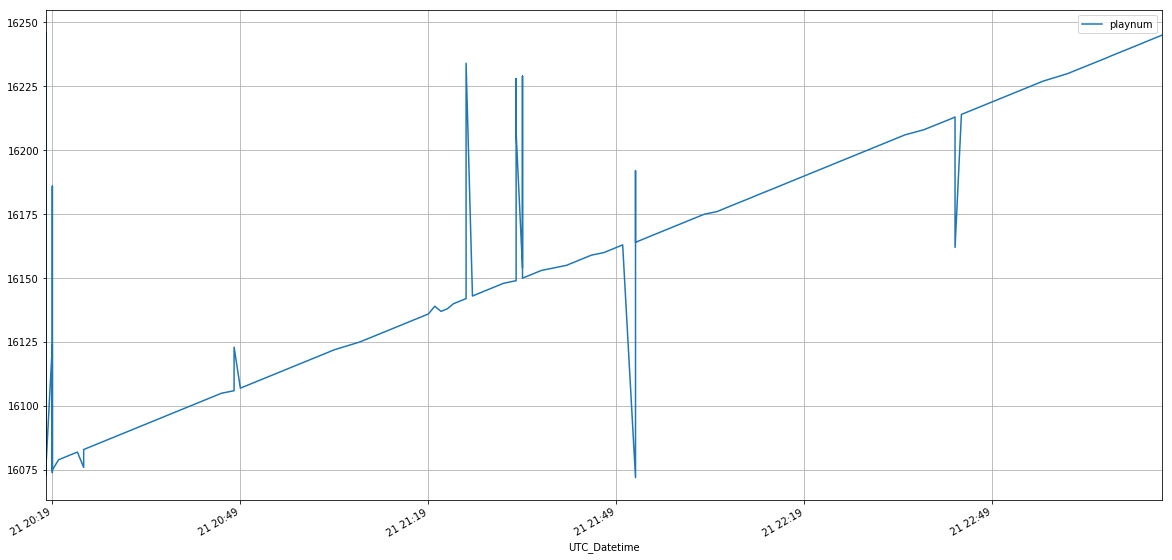

In [411]:
%matplotlib inline

df['playnum'] = df.index
df.plot(x='UTC_Datetime', y='playnum', figsize=(20,10), grid=True)

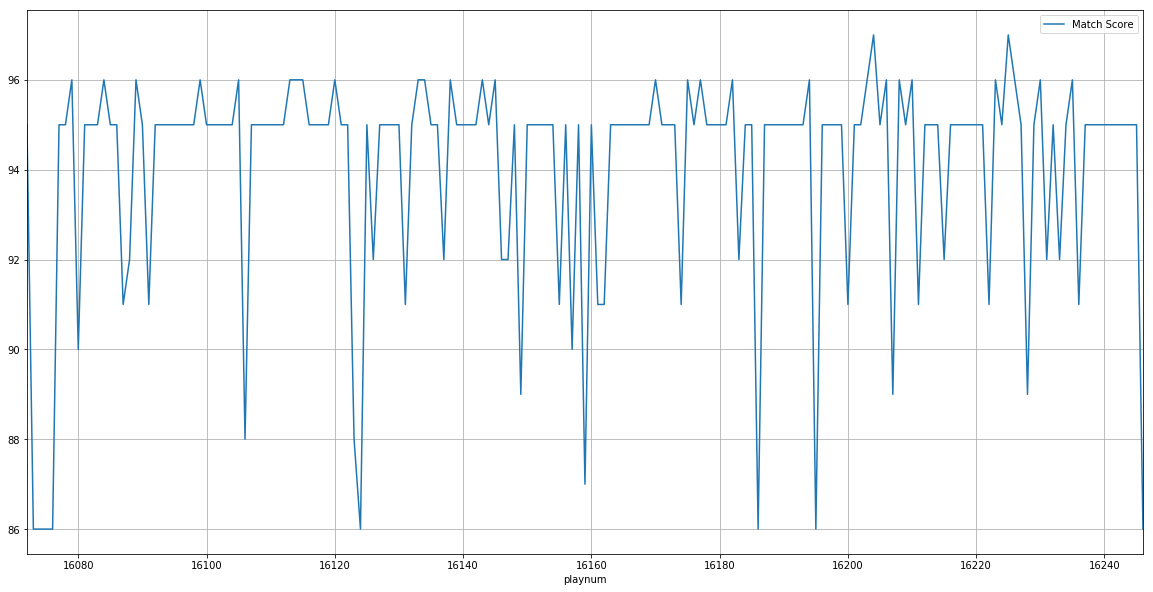

In [412]:
df.plot(x='playnum', y=['Match Score'], figsize=(20,10), grid=True) 

In [400]:
df.to_csv('PatsJags_Match_test.csv')

In [413]:
df2.to_csv('PatsJagsMatch2.csv')

In [422]:
pbptweets2.head()

,Game Title Date,UTC_Datetime,gamedate,screen_name,text,text_cleaned,Game_and_Tweet
tweet_id,,,,,,,
9.059546e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:43:00,2017-09-07,chiefs_pbp,C.Santos kicks 64 yards from KC 35 to NE 1. D....,C.Santos kicks 64 yards from KC 35 to NE 1. D....,Chiefs vs. Patriots 2017-09-07C.Santos kicks ...
9.059548e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:44:01,2017-09-07,chiefs_pbp,1/2 (14:55) NE 12-Brady 18th season as Patriot...,(14:55) NE 12-Brady 18th season as Patriots QB...,Chiefs vs. Patriots 2017-09-07(14:55) NE 12-B...
9.059548e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:44:01,2017-09-07,chiefs_pbp,2/2 T.Brady pass incomplete deep left to D.All...,T.Brady pass incomplete deep left to D.Allen. ...,Chiefs vs. Patriots 2017-09-07T.Brady pass in...
9.059548e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:44:02,2017-09-07,chiefs_pbp,(14:49) T.Brady pass short right to R.Burkhead...,(14:49) T.Brady pass short right to R.Burkhead...,Chiefs vs. Patriots 2017-09-07(14:49) T.Brady...
9.059551e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:45:00,2017-09-07,chiefs_pbp,(14:14) (Shotgun) J.White left guard to NE 43 ...,(14:14) (Shotgun) J.White left guard to NE 43 ...,Chiefs vs. Patriots 2017-09-07(14:14) (Shotgu...


In [425]:
pbptweets2[['Game Title Date','text_cleaned','UTC_Datetime']].sort_values(['Game Title Date','UTC_Datetime']).to_csv('../../data/All_tweets_Feb17.csv')

In [421]:
winpct[['playnum','playId','Game Title Date','text','homeWinPercentage']].sort_values(['Game Title Date','playnum']).to_csv('../../data/All_plays_Feb17.csv')